![CMCC](http://cmcc.ufabc.edu.br/images/logo_site.jpg)
# **Regressão Linear**

#### Este notebook mostra uma implementação básica de Regressão Linear e o uso da biblioteca [MLlib](http://spark.apache.org/docs/1.4.0/api/python/pyspark.ml.html) do PySpark para a tarefa de regressão na base de dados [Million Song Dataset](http://labrosa.ee.columbia.edu/millionsong/) do repositório [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/YearPredictionMSD). Nosso objetivo é predizer o ano de uma música através dos seus atributos de áudio.

#### ** Neste notebook: **
+  ####*Parte 1:* Leitura e *parsing* da base de dados
 + #### *Visualização 1:* Atributos
 + #### *Visualização 2:* Deslocamento das variáveis de interesse
+  ####*Parte 2:* Criar um preditor de referência
 + #### *Visualização 3:* Valores Preditos vs. Verdadeiros
+  ####*Parte 3:* Treinar e avaliar um modelo de regressão linear
 + #### *Visualização 4:* Erro de Treino
+  ####*Parte 4:* Treinar usando MLlib e ajustar os hiperparâmetros
 + #### *Visualização 5:* Predições do Melhor modelo
 + #### *Visualização 6:* Mapa de calor dos hiperparâmetros
+  ####*Parte 5:* Adicionando interações entre atributos
+  ####*Parte 6:* Aplicando na base de dados de Crimes de São Francisco
 
#### Para referência, consulte os métodos relevantes do PySpark em [Spark's Python API](https://spark.apache.org/docs/latest/api/python/pyspark.html#pyspark.RDD) e do NumPy em [NumPy Reference](http://docs.scipy.org/doc/numpy/reference/index.html)

### ** Parte 1: Leitura e *parsing* da base de dados**

#### ** (1a) Verificando os dados disponíveis **

#### Os dados da base que iremos utilizar estão armazenados em um arquivo texto. No primeiro passo vamos transformar os dados textuais em uma RDD e verificar a formatação dos mesmos. Altere a segunda célula para verificar quantas amostras existem nessa base de dados utilizando o método  [count method](https://spark.apache.org/docs/latest/api/python/pyspark.html#pyspark.RDD.count).

#### Reparem que o rótulo dessa base é o primeiro registro, representando o ano.

In [1]:
from pyspark import SparkContext
from pyspark.sql.types import *
from string import Template
import string

In [2]:
import hashlib

class TestFailure(Exception):
  pass
class PrivateTestFailure(Exception):
  pass

class Test(object):
  passed = 0
  numTests = 0
  failFast = False
  private = False

  @classmethod
  def setFailFast(cls):
    cls.failFast = True

  @classmethod
  def setPrivateMode(cls):
    cls.private = True

  @classmethod
  def assertTrue(cls, result, msg=""):
    cls.numTests += 1
    if result == True:
      cls.passed += 1
      print ("1 test passed.")
    else:
      print ("1 test failed. " + msg)
      if cls.failFast:
        if cls.private:
          raise PrivateTestFailure(msg)
        else:
          raise TestFailure(msg)

  @classmethod
  def assertEquals(cls, var, val, msg=""):
    cls.assertTrue(var == val, msg)

  @classmethod
  def assertEqualsHashed(cls, var, hashed_val, msg=""):
    cls.assertEquals(cls._hash(var), hashed_val, msg)

  @classmethod
  def printStats(cls):
    print ("{0} / {1} test(s) passed.".format(cls.passed, cls.numTests))

  @classmethod
  def _hash(cls, x):
    return hashlib.sha1(str(x).encode('utf-8')).hexdigest()

sc = SparkContext()

In [3]:
# carregar base de dados
import os.path
baseDir = os.path.join('C:\\Users\\Lauri\\Desktop')
inputPath = os.path.join('UFABC', 'millionsong.txt')
fileName = os.path.join(baseDir, inputPath)

numPartitions = 14
rawData = sc.textFile(fileName, numPartitions)


In [4]:
# EXERCICIO
numPoints = rawData.count()
print (numPoints)
samplePoints = rawData.take(5)
print (samplePoints)

515345
['2001,49.94357,21.47114,73.07750,8.74861,-17.40628,-13.09905,-25.01202,-12.23257,7.83089,-2.46783,3.32136,-2.31521,10.20556,611.10913,951.08960,698.11428,408.98485,383.70912,326.51512,238.11327,251.42414,187.17351,100.42652,179.19498,-8.41558,-317.87038,95.86266,48.10259,-95.66303,-18.06215,1.96984,34.42438,11.72670,1.36790,7.79444,-0.36994,-133.67852,-83.26165,-37.29765,73.04667,-37.36684,-3.13853,-24.21531,-13.23066,15.93809,-18.60478,82.15479,240.57980,-10.29407,31.58431,-25.38187,-3.90772,13.29258,41.55060,-7.26272,-21.00863,105.50848,64.29856,26.08481,-44.59110,-8.30657,7.93706,-10.73660,-95.44766,-82.03307,-35.59194,4.69525,70.95626,28.09139,6.02015,-37.13767,-41.12450,-8.40816,7.19877,-8.60176,-5.90857,-12.32437,14.68734,-54.32125,40.14786,13.01620,-54.40548,58.99367,15.37344,1.11144,-23.08793,68.40795,-1.82223,-27.46348,2.26327', '2001,48.73215,18.42930,70.32679,12.94636,-10.32437,-24.83777,8.76630,-0.92019,18.76548,4.59210,2.21920,0.34006,44.38997,2056.93836,605.40696,

In [6]:
# TEST Load and check the data (1a)
Test.assertEquals(numPoints, 515345, 'incorrect value for numPoints')
Test.assertEquals(len(samplePoints), 5, 'incorrect length for samplePoints')

1 test passed.
1 test passed.


#### ** (1b) Usando `LabeledPoint` **
#### Na MLlib, bases de dados rotuladas devem ser armazenadas usando o objeto [LabeledPoint](https://spark.apache.org/docs/latest/api/python/pyspark.mllib.html#pyspark.mllib.regression.LabeledPoint).  Escreva a função `parsePoint` que recebe como entrada uma amostra de dados, transforma os dados usandoo comando [unicode.split](https://docs.python.org/2/library/string.html#string.split), e retorna um `LabeledPoint`.  

#### Aplique essa função na variável `samplePoints` da célula anterior e imprima os atributos e rótulo utilizando os atributos `LabeledPoint.features` e `LabeledPoint.label`. Finalmente, calcule o número de atributos nessa base de dados.

In [7]:
from pyspark.mllib.regression import LabeledPoint
import numpy as np

# Here is a sample raw data point:
# '2001.0,0.884,0.610,0.600,0.474,0.247,0.357,0.344,0.33,0.600,0.425,0.60,0.419'
# In this raw data point, 2001.0 is the label, and the remaining values are features

In [8]:
# EXERCICIO
def parsePoint(line):
    """Converts a comma separated unicode string into a `LabeledPoint`.

    Args:
        line (unicode): Comma separated unicode string where the first element is the label and the
            remaining elements are features.

    Returns:
        LabeledPoint: The line is converted into a `LabeledPoint`, which consists of a label and
            features.
    """
    Point = line.split(",", (len(line)-1))
    return LabeledPoint(Point[0], Point[1:])

parsedSamplePoints = list(map(parsePoint,samplePoints))
firstPointFeatures = parsedSamplePoints[0].features
firstPointLabel = parsedSamplePoints[0].label
print (firstPointFeatures, firstPointLabel)

d = len(firstPointFeatures)
print (d)
   

[49.94357,21.47114,73.0775,8.74861,-17.40628,-13.09905,-25.01202,-12.23257,7.83089,-2.46783,3.32136,-2.31521,10.20556,611.10913,951.0896,698.11428,408.98485,383.70912,326.51512,238.11327,251.42414,187.17351,100.42652,179.19498,-8.41558,-317.87038,95.86266,48.10259,-95.66303,-18.06215,1.96984,34.42438,11.7267,1.3679,7.79444,-0.36994,-133.67852,-83.26165,-37.29765,73.04667,-37.36684,-3.13853,-24.21531,-13.23066,15.93809,-18.60478,82.15479,240.5798,-10.29407,31.58431,-25.38187,-3.90772,13.29258,41.5506,-7.26272,-21.00863,105.50848,64.29856,26.08481,-44.5911,-8.30657,7.93706,-10.7366,-95.44766,-82.03307,-35.59194,4.69525,70.95626,28.09139,6.02015,-37.13767,-41.1245,-8.40816,7.19877,-8.60176,-5.90857,-12.32437,14.68734,-54.32125,40.14786,13.0162,-54.40548,58.99367,15.37344,1.11144,-23.08793,68.40795,-1.82223,-27.46348,2.26327] 2001.0
90


In [9]:
# TEST Using LabeledPoint (1b)
Test.assertTrue(isinstance(firstPointLabel, float), 'label must be a float')
expectedX0 = [49.94357,21.47114,73.0775,8.74861,-17.40628,-13.09905,-25.01202,-12.23257,7.83089,-2.46783,3.32136,-2.31521,10.20556,611.10913,951.0896,698.11428,408.98485,383.70912,326.51512,238.11327,251.42414,187.17351,100.42652,179.19498,-8.41558,-317.87038,95.86266,48.10259,-95.66303,-18.06215,1.96984,34.42438,11.7267,1.3679,7.79444,-0.36994,-133.67852,-83.26165,-37.29765,73.04667,-37.36684,-3.13853,-24.21531,-13.23066,15.93809,-18.60478,82.15479,240.5798,-10.29407,31.58431,-25.38187,-3.90772,13.29258,41.5506,-7.26272,-21.00863,105.50848,64.29856,26.08481,-44.5911,-8.30657,7.93706,-10.7366,-95.44766,-82.03307,-35.59194,4.69525,70.95626,28.09139,6.02015,-37.13767,-41.1245,-8.40816,7.19877,-8.60176,-5.90857,-12.32437,14.68734,-54.32125,40.14786,13.0162,-54.40548,58.99367,15.37344,1.11144,-23.08793,68.40795,-1.82223,-27.46348,2.26327]
Test.assertTrue(np.allclose(expectedX0, firstPointFeatures, 1e-4, 1e-4),
                'incorrect features for firstPointFeatures')
Test.assertTrue(np.allclose(2001.0, firstPointLabel), 'incorrect label for firstPointLabel')
Test.assertTrue(d == 90, 'incorrect number of features')


1 test passed.
1 test passed.
1 test passed.
1 test passed.


#### **Visualização 1: Atributos**

#### A próxima célula mostra uma forma de visualizar os atributos através de um mapa de calor. Nesse mapa mostramos os 50 primeiros objetos e seus atributos representados por tons de cinza, sendo o branco representando o valor 0 e o preto representando o valor 1.

#### Esse tipo de visualização ajuda a perceber a variação dos valores dos atributos.

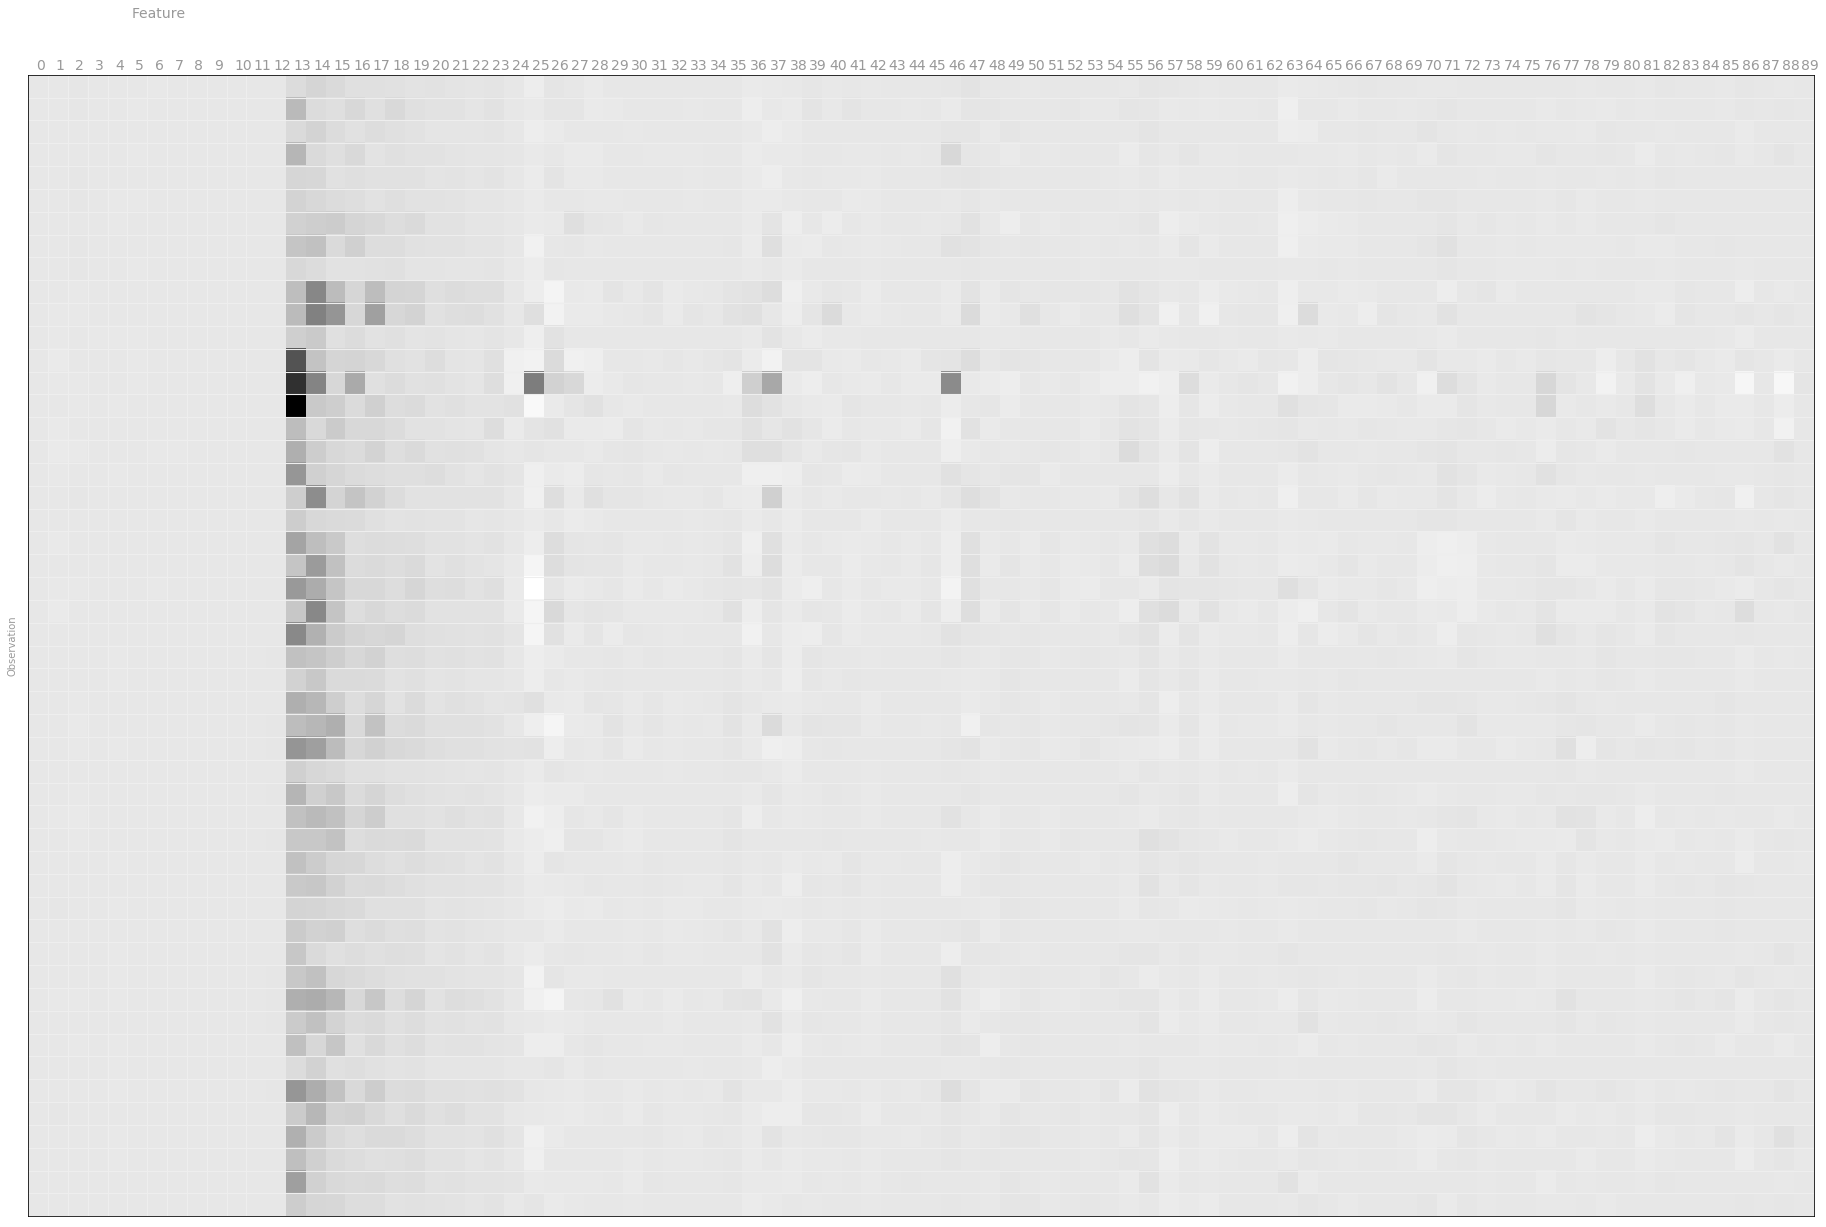

In [48]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

sampleMorePoints = rawData.take(50)

parsedSampleMorePoints = map(parsePoint, sampleMorePoints)
dataValues = list(map(lambda lp: lp.features.toArray(), parsedSampleMorePoints))

def preparePlot(xticks, yticks, figsize=(10.5, 6), hideLabels=False, gridColor='#999999',
                gridWidth=1.0):
    """Template for generating the plot layout."""
    plt.close()
    fig, ax = plt.subplots(figsize=figsize, facecolor='white', edgecolor='white')
    ax.axes.tick_params(labelcolor='#999999', labelsize='10')
    for axis, ticks in [(ax.get_xaxis(), xticks), (ax.get_yaxis(), yticks)]:
        axis.set_ticks_position('none')
        axis.set_ticks(ticks)
        axis.label.set_color('#999999')
        if hideLabels: axis.set_ticklabels([])
    plt.grid(color=gridColor, linewidth=gridWidth, linestyle='-')
    map(lambda position: ax.spines[position].set_visible(False), ['bottom', 'top', 'left', 'right'])
    return fig, ax

# generate layout and plot
fig, ax = preparePlot(np.arange(.5, 11, 1), np.arange(.5, 49, 1), figsize=(32,21), hideLabels=True,
                      gridColor='#eeeeee', gridWidth=1.1)
image = plt.imshow(dataValues,interpolation='nearest', aspect='auto', cmap=cm.Greys)
for x, y, s in zip(np.arange(-.125, 90, 1), np.repeat(-.75, 90), [str(x) for x in range(90)]):
    plt.text(x, y, s, color='#999999', size='14')
plt.text(4.7, -3, 'Feature', color='#999999', size='14'), ax.set_ylabel('Observation')
plt.show()
pass

#### **(1c) Deslocando os rótulos **

#### Para melhor visualizar as soluções obtidas, calcular o erro de predição e visualizar a relação dos atributos com os rótulos, costuma-se deslocar os rótulos para iniciarem em zero.

#### Dessa forma vamos verificar qual é a faixa de valores dos rótulos e, em seguida, subtrair os rótulos pelo menor valor encontrado. Em alguns casos também pode ser interessante normalizar tais valores dividindo pelo valor máximo dos rótulos.

In [11]:
# EXERCICIO
parsedDataInit = rawData.map(lambda x: parsePoint(x))
onlyLabels = parsedDataInit.map(lambda x: x.label)
minYear = onlyLabels.min()
maxYear = onlyLabels.max()
print (maxYear, minYear)


2011.0 1922.0


In [12]:
# TEST Find the range (1c)
Test.assertEquals(len(parsedDataInit.take(1)[0].features), 90,
                  'unexpected number of features in sample point')
sumFeatTwo = parsedDataInit.map(lambda lp: lp.features[2]).sum()
Test.assertTrue(np.allclose(sumFeatTwo, 4462035.88033), 'parsedDataInit has unexpected values')
yearRange = maxYear - minYear
Test.assertTrue(yearRange == 89, 'incorrect range for minYear to maxYear')

1 test passed.
1 test passed.
1 test passed.


In [13]:
# EXERCICIO
parsedData = parsedDataInit.map(lambda x: x)

# Should be a LabeledPoint
print (type(parsedData.take(1)[0]))
# View the first point
print ('\n{0}'.format(parsedData.take(1)))

<class 'pyspark.mllib.regression.LabeledPoint'>

[LabeledPoint(2001.0, [49.94357,21.47114,73.0775,8.74861,-17.40628,-13.09905,-25.01202,-12.23257,7.83089,-2.46783,3.32136,-2.31521,10.20556,611.10913,951.0896,698.11428,408.98485,383.70912,326.51512,238.11327,251.42414,187.17351,100.42652,179.19498,-8.41558,-317.87038,95.86266,48.10259,-95.66303,-18.06215,1.96984,34.42438,11.7267,1.3679,7.79444,-0.36994,-133.67852,-83.26165,-37.29765,73.04667,-37.36684,-3.13853,-24.21531,-13.23066,15.93809,-18.60478,82.15479,240.5798,-10.29407,31.58431,-25.38187,-3.90772,13.29258,41.5506,-7.26272,-21.00863,105.50848,64.29856,26.08481,-44.5911,-8.30657,7.93706,-10.7366,-95.44766,-82.03307,-35.59194,4.69525,70.95626,28.09139,6.02015,-37.13767,-41.1245,-8.40816,7.19877,-8.60176,-5.90857,-12.32437,14.68734,-54.32125,40.14786,13.0162,-54.40548,58.99367,15.37344,1.11144,-23.08793,68.40795,-1.82223,-27.46348,2.26327])]


In [14]:
# TEST Shift labels (1d)
oldSampleFeatures = parsedDataInit.take(1)[0].features
newSampleFeatures = parsedData.take(1)[0].features
Test.assertTrue(np.allclose(oldSampleFeatures, newSampleFeatures),
                'new features do not match old features')
sumFeatTwo = parsedData.map(lambda lp: lp.features[2]).sum()
Test.assertTrue(np.allclose(sumFeatTwo, 4462035.88033), 'parsedData has unexpected values')
minYearNew = parsedData.map(lambda lp: lp.label).min()
maxYearNew = parsedData.map(lambda lp: lp.label).max()
Test.assertTrue(minYearNew == 1922, 'incorrect min year in shifted data')
Test.assertTrue(maxYearNew == 2011, 'incorrect max year in shifted data')


1 test passed.
1 test passed.
1 test passed.
1 test passed.


#### ** (1d) Conjuntos de treino, validação e teste **

#### Como próximo passo, vamos dividir nossa base de dados em conjunto de treino, validação e teste conforme discutido em sala de aula. Use o método [randomSplit method](https://spark.apache.org/docs/latest/api/python/pyspark.html#pyspark.RDD.randomSplit) com os pesos (weights) e a semente aleatória (seed) especificados na célula abaixo parar criar a divisão das bases. Em seguida, utilizando o método `cache()` faça o pré-armazenamento da base processada.

#### Esse comando faz o processamento da base através das transformações e armazena em um novo RDD que pode ficar armazenado em memória, se couber, ou em um arquivo temporário.

In [15]:
# EXERCICIO
weights = [.8, .1, .1]
seed = 42
parsedTrainData, parsedValData, parsedTestData = parsedData.randomSplit(weights, seed)

parsedTrainData.cache()
parsedValData.cache()
parsedTestData.cache()
nTrain = parsedTrainData.count()
nVal = parsedValData.count()
nTest = parsedTestData.count()

print (nTrain, nVal, nTest, nTrain + nVal + nTest)
print (parsedData.count())

412477 51506 51362 515345
515345


In [16]:
parsedTrainData.take(1)

[LabeledPoint(2001.0, [49.94357,21.47114,73.0775,8.74861,-17.40628,-13.09905,-25.01202,-12.23257,7.83089,-2.46783,3.32136,-2.31521,10.20556,611.10913,951.0896,698.11428,408.98485,383.70912,326.51512,238.11327,251.42414,187.17351,100.42652,179.19498,-8.41558,-317.87038,95.86266,48.10259,-95.66303,-18.06215,1.96984,34.42438,11.7267,1.3679,7.79444,-0.36994,-133.67852,-83.26165,-37.29765,73.04667,-37.36684,-3.13853,-24.21531,-13.23066,15.93809,-18.60478,82.15479,240.5798,-10.29407,31.58431,-25.38187,-3.90772,13.29258,41.5506,-7.26272,-21.00863,105.50848,64.29856,26.08481,-44.5911,-8.30657,7.93706,-10.7366,-95.44766,-82.03307,-35.59194,4.69525,70.95626,28.09139,6.02015,-37.13767,-41.1245,-8.40816,7.19877,-8.60176,-5.90857,-12.32437,14.68734,-54.32125,40.14786,13.0162,-54.40548,58.99367,15.37344,1.11144,-23.08793,68.40795,-1.82223,-27.46348,2.26327])]

In [17]:
# TEST Training, validation, and test sets (1e)
Test.assertEquals(parsedTrainData.getNumPartitions(), numPartitions,
                  'parsedTrainData has wrong number of partitions')
Test.assertEquals(parsedValData.getNumPartitions(), numPartitions,
                  'parsedValData has wrong number of partitions')
Test.assertEquals(parsedTestData.getNumPartitions(), numPartitions,
                  'parsedTestData has wrong number of partitions')
Test.assertEquals(len(parsedTrainData.take(1)[0].features), 90,
                  'parsedTrainData has wrong number of features')
sumFeatTwo = (parsedTrainData
              .map(lambda lp: lp.features[2])
              .sum())
sumFeatThree = (parsedValData
                .map(lambda lp: lp.features[3])
                .reduce(lambda x, y: x + y))
sumFeatFour = (parsedTestData
               .map(lambda lp: lp.features[4])
               .reduce(lambda x, y: x + y))
Test.assertTrue(np.allclose([sumFeatTwo, sumFeatThree, sumFeatFour],
                            3569782.3172399979, 63751.916229999981, -337378.7718000001),
                'parsed Train, Val, Test data has unexpected values')
Test.assertTrue(nTrain + nVal + nTest == 515345, 'unexpected Train, Val, Test data set size')
Test.assertEquals(nTrain, 412477, 'unexpected value for nTrain')
Test.assertEquals(nVal, 51506, 'unexpected value for nVal')
Test.assertEquals(nTest, 51362, 'unexpected value for nTest')


1 test passed.
1 test passed.
1 test passed.
1 test passed.
1 test passed.
1 test passed.
1 test passed.
1 test passed.
1 test passed.


### ** Part 2: Criando o modelo de *baseline* **

#### **(2a) Rótulo médio **

#### O baseline é útil para verificarmos que nosso modelo de regressão está funcionando. Ele deve ser um modelo bem simples que qualquer algoritmo possa fazer melhor.

#### Um baseline muito utilizado é fazer a mesma predição independente dos dados analisados utilizando o rótulo médio do conjunto de treino. Calcule a média dos rótulos deslocados para a base de treino, utilizaremos esse valor posteriormente para comparar o erro de predição.  Use um método apropriado para essa tarefa, consulte o [RDD API](https://spark.apache.org/docs/latest/api/python/pyspark.html#pyspark.RDD).

In [18]:
# EXERCICIO
averageTrainYear = (parsedTrainData
                    .map(lambda x: x.label)
                    .mean()
                   )
print (averageTrainYear)

1998.4033267309458


In [19]:
# TEST Average label (2a)
Test.assertTrue(np.allclose(averageTrainYear, 1998.4033267309458),
                'incorrect value for averageTrainYear')

1 test passed.


#### **(2b) Erro quadrático médio **

#### Para comparar a performance em problemas de regressão, geralmente é utilizado o Erro Quadrático Médio ([RMSE](http://en.wikipedia.org/wiki/Root-mean-square_deviation)).  Implemente uma função que calcula o RMSE a partir de um RDD de tuplas (rótulo, predição).

In [63]:
# EXERCICIO
def squaredError(label, prediction):
    """Calculates the the squared error for a single prediction.

    Args:
        label (float): The correct value for this observation.
        prediction (float): The predicted value for this observation.

    Returns:
        float: The difference between the `label` and `prediction` squared.
    """
#    return (np.sqrt(np.mean((np.array(prediction)-np.array(label))**2)))
    return (label - prediction) ** 2

def calcRMSE(labelsAndPreds):
    """Calculates the root mean squared error for an `RDD` of (label, prediction) tuples.

    Args:
        labelsAndPred (RDD of (float, float)): An `RDD` consisting of (label, prediction) tuples.

    Returns:
        float: The square root of the mean of the squared errors.
    """
#    return squaredError(labelsAndPreds.map(lambda x: x[0]).collect(), labelsAndPreds.map(lambda x: x[1]).collect())
    return np.sqrt(labelsAndPreds
                   .map(lambda x: squaredError(x[0], x[1]))
                   .mean())

labelsAndPreds = sc.parallelize([(3., 1.), (1., 2.), (2., 2.)])
# RMSE = sqrt[((3-1)^2 + (1-2)^2 + (2-2)^2) / 3] = 1.291
exampleRMSE = calcRMSE(labelsAndPreds)
print (exampleRMSE)

1.29099444874


In [64]:
# TEST Root mean squared error (2b)
Test.assertTrue(np.allclose(squaredError(3, 1), 4.), 'incorrect definition of squaredError')
Test.assertTrue(np.allclose(exampleRMSE, 1.29099444874), 'incorrect value for exampleRMSE')

1 test passed.
1 test passed.


#### **(2c) RMSE do baseline para os conjuntos de treino, validação e teste **

#### Vamos calcular o RMSE para nossa baseline. Primeiro crie uma RDD de (rótulo, predição) para cada conjunto, e então chame a função `calcRMSE`.

In [65]:
# EXERCICIO
labelsAndPredsTrain = parsedTrainData.map(lambda x: (x.label, averageTrainYear))
rmseTrainBase = calcRMSE(labelsAndPredsTrain)

labelsAndPredsVal = parsedValData.map(lambda x: (x.label, averageTrainYear))
rmseValBase = calcRMSE(labelsAndPredsVal)

labelsAndPredsTest = parsedTestData.map(lambda x: (x.label, averageTrainYear))
rmseTestBase = calcRMSE(labelsAndPredsTest)

print ('Baseline Train RMSE = {0:.3f}'.format(rmseTrainBase))
print ('Baseline Validation RMSE = {0:.3f}'.format(rmseValBase))
print ('Baseline Test RMSE = {0:.3f}'.format(rmseTestBase))

Baseline Train RMSE = 10.924
Baseline Validation RMSE = 10.985
Baseline Test RMSE = 10.930


In [66]:
# TEST Training, validation and test RMSE (2c)
Test.assertTrue(np.allclose([rmseTrainBase, rmseValBase, rmseTestBase],
                            10.924, 10.985, 10.930), 'incorrect RMSE value')

1 test passed.


#### ** Visualização 2: Predição vs. real **

#### Vamos visualizar as predições no conjunto de validação. Os gráficos de dispersão abaixo plotam os pontos com a coordenada X sendo o valor predito pelo modelo e a coordenada Y o valor real do rótulo.

#### O primeiro gráfico mostra a situação ideal, um modelo que acerta todos os rótulos. O segundo gráfico mostra o desempenho do modelo baseline. As cores dos pontos representam o erro quadrático daquela predição, quanto mais próxima do laranja, maior o erro.

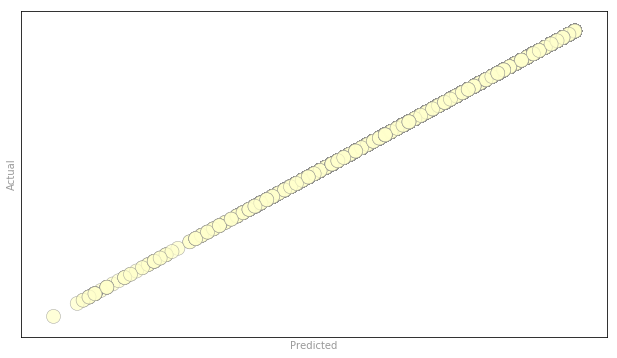

In [25]:
from matplotlib.colors import ListedColormap, Normalize
from matplotlib.cm import get_cmap
cmap = get_cmap('YlOrRd')
norm = Normalize()

actual = np.asarray(parsedValData
                    .map(lambda lp: lp.label)
                    .collect())
error = np.asarray(parsedValData
                   .map(lambda lp: squaredError(lp.label, lp.label))
#                   .map(lambda l, p: squaredError(l, p))
                   .collect())
clrs = cmap(np.asarray(norm(error)))[:,0:3]

fig, ax = preparePlot(np.arange(0, 100, 20), np.arange(0, 100, 20))
plt.scatter(actual, actual, s=14**2, c=clrs, edgecolors='#888888', alpha=0.75, linewidths=0.5)
ax.set_xlabel('Predicted'), ax.set_ylabel('Actual')
plt.show()
pass

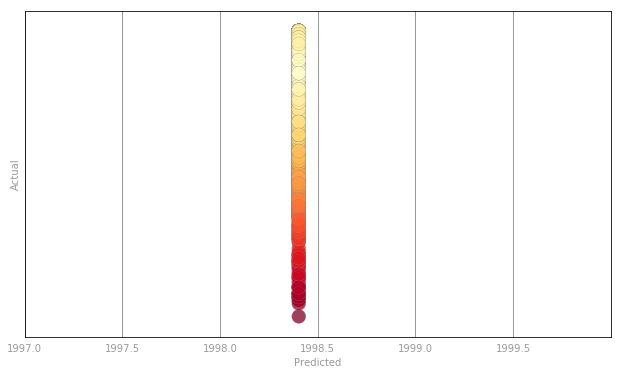

In [26]:
predictions = np.asarray(parsedValData
                         .map(lambda lp: averageTrainYear)
                         .collect())
error = np.asarray(parsedValData
                   .map(lambda lp: squaredError(lp.label, averageTrainYear))
#                   .map(lambda l, p: squaredError(l, p))
                   .collect())
norm = Normalize()
clrs = cmap(np.asarray(norm(error)))[:,0:3]

fig, ax = preparePlot(np.arange(1997, 2000, 0.5), np.arange(0, 100, 20))
ax.set_xlim(1997, 2000)
plt.scatter(predictions, actual, s=14**2, c=clrs, edgecolors='#888888', alpha=0.75, linewidths=0.3)
ax.set_xlabel('Predicted'), ax.set_ylabel('Actual')
plt.show()

### ** Parte 3: Treinando e avaliando o modelo de regressão linear **

#### ** (3a) Gradiente do erro **

#### Vamos implementar a regressão linear através do gradiente descendente.
#### Lembrando que para atualizar o peso da regressão linear fazemos: $$ \scriptsize \mathbf{w}_{i+1} = \mathbf{w}_i - \alpha_i \sum_j (\mathbf{w}_i^\top\mathbf{x}_j  - y_j) \mathbf{x}_j \,.$$ onde $ \scriptsize i $ é a iteração do algoritmo, e $ \scriptsize j $ é o objeto sendo observado no momento.

#### Primeiro, implemente uma função que calcula esse gradiente do erro para certo objeto: $ \scriptsize (\mathbf{w}^\top \mathbf{x} - y) \mathbf{x} \, ,$ e teste a função em dois exemplos. Use o método `DenseVector` [dot](http://spark.apache.org/docs/latest/api/python/pyspark.mllib.html#pyspark.mllib.linalg.DenseVector.dot) para representar a lista de atributos (ele tem funcionalidade parecida com o `np.array()`).

In [27]:
from pyspark.mllib.linalg import DenseVector

In [28]:
# EXERCICIO
def gradientSummand(weights, lp):
    """Calculates the gradient summand for a given weight and `LabeledPoint`.

    Note:
        `DenseVector` behaves similarly to a `numpy.ndarray` and they can be used interchangably
        within this function.  For example, they both implement the `dot` method.

    Args:
        weights (DenseVector): An array of model weights (betas).
        lp (LabeledPoint): The `LabeledPoint` for a single observation.

    Returns:
        DenseVector: An array of values the same length as `weights`.  The gradient summand.
    """
    return (weights.dot(lp.features) - lp.label) * lp.features

exampleW = DenseVector([1, 1, 1])
exampleLP = LabeledPoint(2.0, [3, 1, 4])

summandOne = gradientSummand(exampleW, exampleLP)
print (summandOne)

exampleW = DenseVector([.24, 1.2, -1.4])
exampleLP = LabeledPoint(3.0, [-1.4, 4.2, 2.1])
summandTwo = gradientSummand(exampleW, exampleLP)
print (summandTwo)

[18.0,6.0,24.0]
[1.7304,-5.1912,-2.5956]


In [29]:
# TEST Gradient summand (3a)
Test.assertTrue(np.allclose(summandOne, [18., 6., 24.]), 'incorrect value for summandOne')
Test.assertTrue(np.allclose(summandTwo, [1.7304,-5.1912,-2.5956]), 'incorrect value for summandTwo')

1 test passed.
1 test passed.


#### ** (3b) Use os pesos para fazer a predição **
#### Agora, implemente a função  `getLabeledPredictions` que recebe como parâmetro o conjunto de pesos e um `LabeledPoint` e retorna uma tupla (rótulo, predição). Lembre-se que podemos predizer um rótulo calculando o produto interno dos pesos com os atributos.

In [30]:
# EXERCICIO
def getLabeledPrediction(weights, observation):
    """Calculates predictions and returns a (label, prediction) tuple.

    Note:
        The labels should remain unchanged as we'll use this information to calculate prediction
        error later.

    Args:
        weights (np.ndarray): An array with one weight for each features in `trainData`.
        observation (LabeledPoint): A `LabeledPoint` that contain the correct label and the
            features for the data point.

    Returns:
        tuple: A (label, prediction) tuple.
    """
    return (float(weights.dot(observation.features)), float(observation.label))

weights = np.array([1.0, 1.5])
predictionExample = sc.parallelize([LabeledPoint(2, np.array([1.0, .5])),
                                    LabeledPoint(1.5, np.array([.5, .5]))])
labelsAndPredsExample = predictionExample.map(lambda lp: getLabeledPrediction(weights, lp))
print (labelsAndPredsExample.collect())

[(1.75, 2.0), (1.25, 1.5)]


In [31]:
labelsAndPredsExample.collect()

[(1.75, 2.0), (1.25, 1.5)]

In [34]:
# TEST Use weights to make predictions (3b)
Test.assertEquals(labelsAndPredsExample.collect(), [(1.75, 2.0), (1.25, 1.5)],
                  'incorrect definition for getLabeledPredictions')

1 test passed.


#### ** (3c) Gradiente descendente **
#### Finalmente, implemente o algoritmo gradiente descendente para regressão linear e teste a função em um exemplo.

In [33]:
# EXERCICIO
def linregGradientDescent(trainData, numIters):
    """Calculates the weights and error for a linear regression model trained with gradient descent.

    Note:
        `DenseVector` behaves similarly to a `numpy.ndarray` and they can be used interchangably
        within this function.  For example, they both implement the `dot` method.

    Args:
        trainData (RDD of LabeledPoint): The labeled data for use in training the model.
        numIters (int): The number of iterations of gradient descent to perform.

    Returns:
        (np.ndarray, np.ndarray): A tuple of (weights, training errors).  Weights will be the
            final weights (one weight per feature) for the model, and training errors will contain
            an error (RMSE) for each iteration of the algorithm.
    """
    # The length of the training data
    n = trainData.count()
    # The number of features in the training data
    d = len(trainData.first().features)
    w = np.zeros(d)
    alpha = 1.0
    # We will compute and store the training error after each iteration
    errorTrain = np.zeros(numIters)
    for i in range(numIters):
        # Use getLabeledPrediction from (3b) with trainData to obtain an RDD of (label, prediction)
        # tuples.  Note that the weights all equal 0 for the first iteration, so the predictions will
        # have large errors to start.
        labelsAndPredsTrain = trainData.map(lambda x: getLabeledPrediction(w, x))
        errorTrain[i] = calcRMSE(labelsAndPredsTrain)

        # Calculate the `gradient`.  Make use of the `gradientSummand` function you wrote in (3a).
        # Note that `gradient` sould be a `DenseVector` of length `d`.
        gradient = trainData.map(lambda x: gradientSummand(w, x)).sum()

        # Update the weights
        alpha_i = alpha / (n * np.sqrt(i+1))
        w -= alpha_i*gradient
    return w, errorTrain

# create a toy dataset with n = 10, d = 3, and then run 5 iterations of gradient descent
# note: the resulting model will not be useful; the goal here is to verify that
# linregGradientDescent is working properly
exampleN = 10
exampleD = 3
exampleData = (sc
               .parallelize(parsedTrainData.take(exampleN))
               .map(lambda lp: LabeledPoint(lp.label, lp.features[0:exampleD])))
print (exampleData.take(2))
exampleNumIters = 5
exampleWeights, exampleErrorTrain = linregGradientDescent(exampleData, exampleNumIters)
print (exampleWeights)

[LabeledPoint(2001.0, [49.94357,21.47114,73.0775]), LabeledPoint(2001.0, [48.73215,18.4293,70.32679])]
[  1.36538138e+19   6.00001955e+18   1.85247266e+19]


In [40]:
print (exampleErrorTrain)

[  2.00170110e+03   1.19624042e+07   5.47170727e+10   2.04403230e+14
   6.61250082e+17]


In [41]:
# TEST Gradient descent (3c)
expectedOutput = [1.36538138e+19, 6.00001955e+18, 1.85247266e+19]
Test.assertTrue(np.allclose(exampleWeights, expectedOutput), 'value of exampleWeights is incorrect')
expectedError = [2.00170110e+03, 1.19624042e+07, 5.47170727e+10, 2.04403230e+14, 6.61250082e+17]
Test.assertTrue(np.allclose(exampleErrorTrain, expectedError),
                'value of exampleErrorTrain is incorrect')

1 test passed.
1 test passed.


#### ** (3d) Treinando o modelo na base de dados **

#### Agora iremos treinar o modelo de regressão linear na nossa base de dados de treino e calcular o RMSE na base de validação. Lembrem-se que não devemos utilizar a base de teste até que o melhor parâmetro do modelo seja escolhido. 

#### Para essa tarefa vamos utilizar as funções linregGradientDescent, getLabeledPrediction e calcRMSE já implementadas.

In [42]:
# EXERCICIO
numIters = 10
weightsLR0, errorTrainLR0 = linregGradientDescent(parsedTrainData, numIters)

labelsAndPreds = parsedValData.map(lambda x: getLabeledPrediction(weightsLR0, x))
rmseValLR0 = calcRMSE(labelsAndPreds)

print ('Validation RMSE:\n\tBaseline = {0:.3f}\n\tLR0 = {1:.3f}'.format(rmseValBase,
                                                                       rmseValLR0))

Validation RMSE:
	Baseline = 10.985
	LR0 = 6342868136180982826212403124686520565208225987218408608554478730945232896.000


In [44]:
# TEST Train the model (3d)
expectedOutput = [-1.21370028e+67, 1.65578762e+66, -8.84542211e+65, -1.08430903e+66, 
                  8.85970286e+65, 2.07261305e+66, 7.50881584e+65, 4.11010814e+65, 
                  -8.41655342e+65, -5.69813811e+65, 1.02902891e+65, -8.13344867e+65,
                  -1.13979126e+67, -9.50674944e+68, -7.29360070e+68, -5.64622398e+68,
                  -3.11741305e+68, -3.12347117e+68, -2.06771605e+68, -1.83222659e+68,
                  -1.32805903e+68, -1.11528166e+68, -1.02470899e+68, -9.59141131e+67,
                  -1.51828500e+67, -4.56270505e+67, 1.37474646e+67, 1.02938832e+67,
                  -6.13895983e+66, -1.77808530e+67, -1.66192122e+66, -7.63107644e+66,
                  -1.67055047e+66, -2.51855869e+65, 1.38263068e+66, -2.69119054e+67,
                  3.17825852e+66, -4.72358679e+67, 6.09665715e+67, -6.82740405e+66,
                  1.62114097e+66, -2.56223988e+66, 1.66838511e+67, -8.89235245e+65,
                  3.12254473e+65, -3.34384217e+66, -2.07710590e+67, -5.46785286e+67,
                  3.27758425e+67, -3.91234574e+66, -3.02509944e+66, -9.21891591e+66,
                  -4.90427461e+66, -4.09856528e+65, 4.58454120e+66, -3.46769394e+67,
                  -3.92566503e+67, -6.31515227e+66, -1.45071351e+67, 6.48695405e+66,
                  -2.47686617e+66, 9.90379368e+65, -1.54808802e+66, 4.87830249e+67,
                  4.33081136e+66, 1.46077725e+66, -1.12533759e+66, -1.08987747e+67,
                  -9.58021531e+66, 4.62886056e+65, 1.54192180e+67, 2.28379531e+66,
                  9.92397049e+66, 2.68526132e+66, 7.95826426e+66, 2.71075696e+66,
                  -1.99974730e+66, -6.58764681e+66, 3.97844745e+67, -8.04469264e+66,
                  -5.94737687e+66, 2.93203645e+67, -1.70289188e+67, -1.23805873e+67,
                  1.81313870e+65, -5.42399392e+66, 8.96866588e+66, -1.67399437e+66,
                  -1.01229368e+67, -8.31003145e+65]
Test.assertTrue(np.allclose(weightsLR0, expectedOutput), 'incorrect value for weightsLR0')

1 test passed.


#### ** Visualização 3: Erro de Treino **
#### Vamos verificar o comportamento do algoritmo durante as iterações. Para isso vamos plotar um gráfico em que o eixo x representa a iteração e o eixo y o log do RMSE. O primeiro gráfico mostra as primeiras 50 iterações enquanto o segundo mostra as últimas 44 iterações. Note que inicialmente o erro cai rapidamente, quando então o gradiente descendente passa a fazer apenas pequenos ajustes.

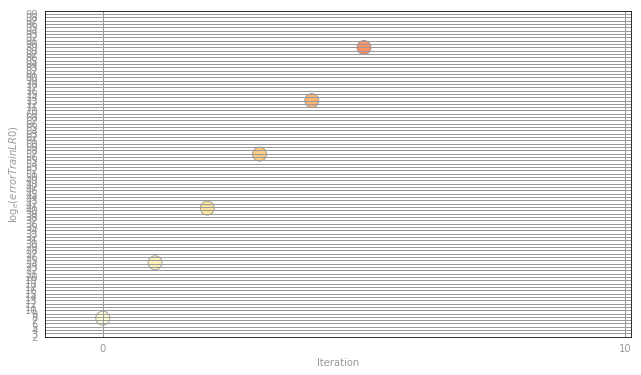

In [52]:
norm = Normalize()
clrs = cmap(np.asarray(norm(np.log(errorTrainLR0))))[:,0:3]

#fig, ax = preparePlot(np.arange(0, 60, 10), np.arange(2, 6, 1))
fig, ax = preparePlot(np.arange(0, 60, 10), np.arange(2, 100, 1))
#ax.set_ylim(2, 6)
ax.set_ylim(2, 100)
plt.scatter(range(0, numIters), np.log(errorTrainLR0), s=14**2, c=clrs, edgecolors='#888888', alpha=0.75)
ax.set_xlabel('Iteration'), ax.set_ylabel(r'$\log_e(errorTrainLR0)$')
plt.show()
pass

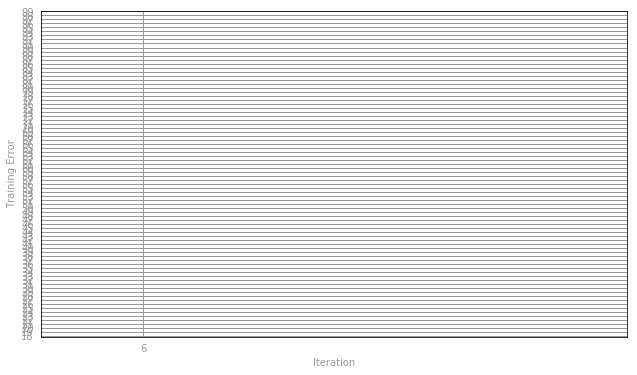

In [57]:
norm = Normalize()
clrs = cmap(np.asarray(norm(errorTrainLR0[6:])))[:,0:3]

#fig, ax = preparePlot(np.arange(0, 60, 10), np.arange(17, 22, 1))
fig, ax = preparePlot(np.arange(0, 60, 10), np.arange(17, 100, 1))
#ax.set_ylim(17.8, 21.2)
ax.set_ylim(17.8, 99.2)
plt.scatter(range(0, numIters-6), errorTrainLR0[6:], s=14**2, c=clrs, edgecolors='#888888', alpha=0.75)
#ax.set_xticklabels(map(str, range(6, 66, 10)))
ax.set_xticklabels(map(str, range(6, 1000, 1000)))
ax.set_xlabel('Iteration'), ax.set_ylabel(r'Training Error')
plt.show()
pass

### ** Part 4: Treino utilizando MLlib e Busca em Grade (Grid Search) **

#### **(4a) `LinearRegressionWithSGD` **

#### Nosso teste inicial já conseguiu obter um desempenho melhor que o baseline, mas vamos ver se conseguimos fazer melhor introduzindo a ordenada de origem da reta além de outros ajustes no algoritmo.  MLlib [LinearRegressionWithSGD](https://spark.apache.org/docs/latest/api/python/pyspark.mllib.html#pyspark.mllib.regression.LinearRegressionWithSGD) implementa o mesmo algoritmo da parte (3b), mas de forma mais eficiente para o contexto distribuído e com várias funcionalidades adicionais. 

#### Primeiro utilize a função LinearRegressionWithSGD para treinar um modelo com regularização L2 (Ridge) e com a ordenada de origem. Esse método retorna um [LinearRegressionModel](https://spark.apache.org/docs/latest/api/python/pyspark.mllib.html#pyspark.mllib.regression.LinearRegressionModel).  

#### Em seguida, use os atributos [weights](http://spark.apache.org/docs/latest/api/python/pyspark.mllib.html#pyspark.mllib.regression.LinearRegressionModel.weights) e  [intercept](http://spark.apache.org/docs/latest/api/python/pyspark.mllib.html#pyspark.mllib.regression.LinearRegressionModel.intercept) para imprimir o modelo encontrado.

In [58]:
from pyspark.mllib.regression import LinearRegressionWithSGD
# Values to use when training the linear regression model
numIters = 500  # iterations
alpha = 1.0  # step
miniBatchFrac = 1.0  # miniBatchFraction
reg = 1e-1  # regParam
regType = 'l2'  # regType
useIntercept = True  # intercept

In [59]:
# EXERCICIO
firstModel = LinearRegressionWithSGD.train(parsedTrainData, iterations = numIters, step = alpha, miniBatchFraction = 1.0,
                                          regParam=reg,regType=regType, intercept=useIntercept)

# weightsLR1 stores the model weights; interceptLR1 stores the model intercept
weightsLR1 = firstModel.weights
interceptLR1 = firstModel.intercept
print (weightsLR1, interceptLR1)

C:\Users\lauri\Anaconda3\lib\site-packages\pyspark\mllib\regression.py:281: UserWarning: Deprecated in 2.0.0. Use ml.regression.LinearRegression.
  warnings.warn("Deprecated in 2.0.0. Use ml.regression.LinearRegression.")


[nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan] nan


In [68]:
# TEST LinearRegressionWithSGD (4a)
expectedIntercept = 13.3335907631
expectedWeights = [16.682292427, 14.7439059559, -0.0935105608897, 6.22080088829, 4.01454261926, -3.30214858535,
                   11.0403027232, 2.67190962854, 7.18925791279, 4.46093254586, 8.14950409475, 2.75135810882]

#### **(4b) Predição**
#### Agora use o método [LinearRegressionModel.predict()](http://spark.apache.org/docs/latest/api/python/pyspark.mllib.html#pyspark.mllib.regression.LinearRegressionModel.predict) para fazer a predição de um objeto. Passe o atributo `features` de um `LabeledPoint` comp parâmetro.

In [70]:
# EXERCICIO
samplePoint = parsedTrainData.take(1)[0]
samplePrediction = firstModel.predict(samplePoint.features)
print (samplePrediction)

nan


#### ** (4c) Avaliar RMSE **

#### Agora avalie o desempenho desse modelo no teste de validação. Use o método `predict()` para criar o RDD `labelsAndPreds` RDD, e então use a função `calcRMSE()` da Parte (2b) para calcular o RMSE.

In [75]:
parsedValData.take(1)[0]

LabeledPoint(2007.0, [45.17809,46.34234,-40.65357,-2.47909,1.21253,-0.65302,-6.95536,-12.2004,17.02512,2.00002,-1.87785,9.85499,25.59837,1905.18577,3676.09074,1976.85531,913.11216,1957.52415,955.98525,942.72667,439.85991,591.66138,493.4077,496.38516,33.94285,-255.90134,-762.28079,-66.10935,-128.02217,198.12908,-34.44957,176.00397,-140.80069,-22.5638,12.77945,193.30164,314.20949,576.29519,-429.58643,-72.20157,59.59139,-5.1211,-182.15958,31.8012,-10.6738,-8.13459,-122.96813,208.69408,-138.66307,119.52244,-17.48938,75.58779,93.29243,85.83507,47.13972,312.85482,135.50478,-32.47886,49.67063,-214.7318,-77.83503,-47.26902,7.58366,-352.56581,-36.15655,-53.39933,-98.60417,-82.37799,45.81588,-16.91676,18.35888,-315.68965,-3.14554,125.45269,-130.18808,-3.06337,42.26602,-9.04929,26.4157,23.36165,-4.36742,-87.55285,-70.79677,76.57355,-7.71727,3.26926,-298.49845,11.49326,-89.21804,-15.09719])

In [82]:
# EXERCICIO
labelsAndPreds = parsedValData.map(lambda lp: (lp.label, firstModel.predict(lp.features)))
rmseValLR1 = calcRMSE(labelsAndPreds)

print (rmseValBase, rmseValLR0, rmseValLR1)

10.9845895639 6.34286813618e+72 nan


C:\Users\lauri\Anaconda3\lib\site-packages\pyspark\statcounter.py:80: RuntimeWarning: invalid value encountered in maximum
  self.maxValue = maximum(self.maxValue, other.maxValue)
C:\Users\lauri\Anaconda3\lib\site-packages\pyspark\statcounter.py:81: RuntimeWarning: invalid value encountered in minimum
  self.minValue = minimum(self.minValue, other.minValue)


In [83]:
# TEST Evaluate RMSE (4c)
Test.assertTrue(np.allclose(rmseValBase, 10.9845895639), 'incorrect value for rmseValLR1')

1 test passed.


#### ** (4d) Grid search **
#### Já estamos superando o baseline em pelo menos dois anos na média, vamos ver se encontramos um conjunto de parâmetros melhor.  Faça um grid search para encontrar um bom parâmetro de regularização.  Tente valores para `regParam` dentro do conjunto `1e-10`, `1e-5`, e `1`.

In [88]:
# EXERCICIO
bestRMSE = rmseValLR1
bestRegParam = reg
bestModel = firstModel

numIters = 500
alpha = 1.0
miniBatchFrac = 1.0
for reg in [1e-10, 1e-5, 1.0]:
    model = LinearRegressionWithSGD.train(parsedTrainData, numIters, alpha,
                                          miniBatchFrac, regParam=reg,
                                          regType='l2', intercept=True)
    labelsAndPreds = parsedValData.map(lambda lp: (lp.label, model.predict(lp.features)))
    rmseValGrid = calcRMSE(labelsAndPreds)
    print (rmseValGrid)

    if rmseValGrid < bestRMSE:
        bestRMSE = rmseValGrid
        bestRegParam = reg
        bestModel = model
rmseValLRGrid = bestRMSE

print (rmseValBase, rmseValLR0, rmseValLR1, rmseValLRGrid)

C:\Users\lauri\Anaconda3\lib\site-packages\pyspark\mllib\regression.py:281: UserWarning: Deprecated in 2.0.0. Use ml.regression.LinearRegression.
  warnings.warn("Deprecated in 2.0.0. Use ml.regression.LinearRegression.")
C:\Users\lauri\Anaconda3\lib\site-packages\pyspark\statcounter.py:80: RuntimeWarning: invalid value encountered in maximum
  self.maxValue = maximum(self.maxValue, other.maxValue)
C:\Users\lauri\Anaconda3\lib\site-packages\pyspark\statcounter.py:81: RuntimeWarning: invalid value encountered in minimum
  self.minValue = minimum(self.minValue, other.minValue)


nan
nan
nan
10.9845895639 6.34286813618e+72 nan nan


In [89]:
# TEST Grid search (4d)
Test.assertTrue(np.allclose(6.34286813618e+72, rmseValLR0), 'incorrect value for rmseValLRGrid')

1 test passed.


#### ** Visualização 5: Predições do melhor modelo**
#### Agora, vamos criar um gráfico para verificar o desempenho do melhor modelo. Reparem nesse gráfico que a quantidade de pontos mais escuros reduziu bastante em relação ao baseline.

C:\Users\lauri\Anaconda3\lib\site-packages\matplotlib\colors.py:496: RuntimeWarning: invalid value encountered in less
  cbook._putmask(xa, xa < 0.0, -1)


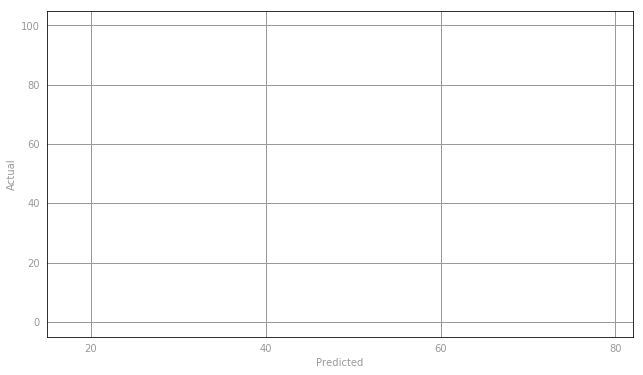

In [93]:
predictions = np.asarray(parsedValData
                         .map(lambda lp: bestModel.predict(lp.features))
                         .collect())
actual = np.asarray(parsedValData
                    .map(lambda lp: lp.label)
                    .collect())
error = np.asarray(parsedValData
                   .map(lambda lp: (lp.label, bestModel.predict(lp.features)))
                   .map(lambda x: squaredError(x[0], x[1]))
                   .collect())

norm = Normalize()
clrs = cmap(np.asarray(norm(error)))[:,0:3]

fig, ax = preparePlot(np.arange(0, 120, 20), np.arange(0, 120, 20))
ax.set_xlim(15, 82), ax.set_ylim(-5, 105)
plt.scatter(predictions, actual, s=14**2, c=clrs, edgecolors='#888888', alpha=0.75, linewidths=.5)
ax.set_xlabel('Predicted'), ax.set_ylabel(r'Actual')
plt.show()


#### ** (4e) Grid Search para o valor de alfa e número de iterações **

####Agora, vamos verificar diferentes valores para alfa e número de iterações para perceber o impacto desses parâmetros em nosso modelo. Especificamente tente os valores  `1e-5` e `10` para `alpha` e os valores `500` e `5` para número de iterações. Avalie todos os modelos no conjunto de valdação.  Reparem que com um valor baixo de alpha, o algoritmo necessita de muito mais iterações para convergir ao ótimo, enquanto um valor muito alto para alpha, pode fazer com que o algoritmo não encontre uma solução.

In [95]:
# EXERCICIO
reg = bestRegParam
modelRMSEs = []

for alpha in [1e-5, 10]:
    for numIters in [500, 5]:
        model = LinearRegressionWithSGD.train(parsedTrainData, numIters, alpha,
                                              miniBatchFrac, regParam=reg,
                                              regType='l2', intercept=True)
        labelsAndPreds = parsedValData.map(lambda lp: (lp.label, model.predict(lp.features)))
        rmseVal = calcRMSE(labelsAndPreds)
        print (alpha, numIters, rmseVal)
        modelRMSEs.append(rmseVal)

C:\Users\lauri\Anaconda3\lib\site-packages\pyspark\mllib\regression.py:281: UserWarning: Deprecated in 2.0.0. Use ml.regression.LinearRegression.
  warnings.warn("Deprecated in 2.0.0. Use ml.regression.LinearRegression.")
C:\Users\lauri\Anaconda3\lib\site-packages\pyspark\statcounter.py:80: RuntimeWarning: invalid value encountered in maximum
  self.maxValue = maximum(self.maxValue, other.maxValue)
C:\Users\lauri\Anaconda3\lib\site-packages\pyspark\statcounter.py:81: RuntimeWarning: invalid value encountered in minimum
  self.minValue = minimum(self.minValue, other.minValue)


1e-05 500 nan
1e-05 5 4.02493181184e+13
10 500 nan
10 5 4.20522931042e+43


In [96]:
# TEST Vary alpha and the number of iterations (4e)
expectedResults = sorted([56.969705, 56.892949, 355124752.221221])
Test.assertTrue(np.allclose(sorted(modelRMSEs)[:3], expectedResults), 'incorrect value for modelRMSEs')

1 test failed. incorrect value for modelRMSEs


### ** Parte 5: Adicionando atributos não-lineares **

#### ** (5a) Interações par a par **

#### Conforme mencionado em aula, os modelos de regressão linear conseguem capturar as relações lineares entre os atributos e o rótulo. Porém, em muitos casos a relação entre eles é não-linear.

#### Uma forma de resolver tal problema é criando mais atributos com características não-lineares, como por exemplo a expansão quadrática dos atributos originais. Escreva uma função `twoWayInteractions` que recebe um  `LabeledPoint` e gera um novo `LabeledPoint` que contém os atributos antigos e as interações par a par entre eles. Note que um objeto com 3 atributos terá nove interações ( $ \scriptsize 3^2 $ ) par a par.

#### Para facilitar, utilize o método [itertools.product](https://docs.python.org/2/library/itertools.html#itertools.product) para gerar tuplas para cada possível interação. Utilize também [np.hstack](http://docs.scipy.org/doc/numpy/reference/generated/numpy.hstack.html#numpy.hstack) para concatenar dois vetores.

In [98]:
# EXERCICIO
import itertools

def twoWayInteractions(lp):
    """Creates a new `LabeledPoint` that includes two-way interactions.

    Note:
        For features [x, y] the two-way interactions would be [x^2, x*y, y*x, y^2] and these
        would be appended to the original [x, y] feature list.

    Args:
        lp (LabeledPoint): The label and features for this observation.

    Returns:
        LabeledPoint: The new `LabeledPoint` should have the same label as `lp`.  Its features
            should include the features from `lp` followed by the two-way interaction features.
    """
    newfeats = list(itertools.product(range(len(lp.features)),range(len(lp.features))))
    return LabeledPoint(lp.label, np.hstack((lp.features,[lp.features[i] * lp.features[j] for (i,j) in newfeats])))
    #return lp
    

print (twoWayInteractions(LabeledPoint(0.0, [2, 3])))

# Transform the existing train, validation, and test sets to include two-way interactions.
trainDataInteract = parsedTrainData.map(twoWayInteractions)
valDataInteract = parsedValData.map(twoWayInteractions)
testDataInteract = parsedTestData.map(twoWayInteractions)

(0.0,[2.0,3.0,4.0,6.0,6.0,9.0])


In [102]:
sum(testDataInteract.take(1)[0].features)

60985581.539280973

In [103]:
# TEST Add two-way interactions (5a)
twoWayExample = twoWayInteractions(LabeledPoint(0.0, [2, 3]))
Test.assertTrue(np.allclose(sorted(twoWayExample.features),
                            sorted([2.0, 3.0, 4.0, 6.0, 6.0, 9.0])),
                'incorrect features generatedBy twoWayInteractions')
twoWayPoint = twoWayInteractions(LabeledPoint(1.0, [1, 2, 3]))
Test.assertTrue(np.allclose(sorted(twoWayPoint.features),
                            sorted([1.0,2.0,3.0,1.0,2.0,3.0,2.0,4.0,6.0,3.0,6.0,9.0])),
                'incorrect features generated by twoWayInteractions')
Test.assertEquals(twoWayPoint.label, 1.0, 'incorrect label generated by twoWayInteractions')
Test.assertTrue(np.allclose(sum(trainDataInteract.take(1)[0].features), 18166903.276942048),
                'incorrect features in trainDataInteract')
Test.assertTrue(np.allclose(sum(valDataInteract.take(1)[0].features), 171415869.19070321),
                'incorrect features in valDataInteract')
Test.assertTrue(np.allclose(sum(testDataInteract.take(1)[0].features), 60985581.539280973),
                'incorrect features in testDataInteract')

1 test passed.
1 test passed.
1 test passed.
1 test passed.
1 test passed.
1 test passed.


#### ** (5b) Construindo um novo modelo **

#### Agora construa um novo modelo usando esses novos atributos. Repare que idealmente, com novos atributos, você deve realizar um novo Grid Search para determinar os novos parâmetros ótimos, uma vez que os parâmetros do modelo anterior não necessariamente funcionarão aqui.

#### Para este exercício, os parâmetros já foram otimizados.

In [ ]:
# EXERCICIO
numIters = 5
alpha = 1.0
miniBatchFrac = 1.0
reg = 1e-10

modelInteract = LinearRegressionWithSGD.train(trainDataInteract, numIters, alpha,
                                              miniBatchFrac, regParam=reg,
                                              regType='l2', intercept=True)
labelsAndPredsInteract = valDataInteract.map(lambda lp: (lp.label, modelInteract.predict(lp.features)))
rmseValInteract = calcRMSE(labelsAndPredsInteract)

print (rmseValBase, rmseValLR0, rmseValLR1, rmseValLRGrid, rmseValInteract)

In [ ]:
# TEST Build interaction model (5b)
Test.assertTrue(np.allclose(rmseValInteract, 15.6894664683), 'incorrect value for rmseValInteract')

#### ** (5c) Avaliando o modelo de interação **

#### Finalmente, temos que o melhor modelo para o conjunto de validação foi o modelo de interação. Na prática esse seria o modelo escolhido para aplicar nos modelos não-rotulados. Vamos ver como essa escolha se sairia utilizand a base de teste nesse modelo e no baseline.

In [ ]:
# EXERCICIO
labelsAndPredsTest = testDataInteract.map(lambda lp: (lp.label, modelInteract.predict(lp.features)))
rmseTestInteract = calcRMSE(labelsAndPredsTest)

print (rmseTestBase, rmseTestInteract))

In [ ]:
# TEST Evaluate interaction model on test data (5c)
Test.assertTrue(np.allclose(rmseTestInteract, 16.3272040537),
                'incorrect value for rmseTestInteract')